# CNN from scratch using AI
> without backpropagation

In [20]:
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def im2col(input_data, filter_h, filter_w, stride=1,  pad=0):
    """
    입력 데이터를 필가 적용될 영역마다 잘라서 열(column)로 전개하는 함수
    
    Args:
        Input_data (batch_size, n_channel, h, w) : 4_dimension
        filter_h, filter_w : 필터 높이, 너비
    
    Returns:
        (윈도우 총 개수, 윈도우 하나의 크기)

    """
    
    N, C, H, W = input_data.shape

    # 1. 출력 크기 계산
    out_h = (H + 2*pad - filter_h) // stride + 1
    out_w = (W + 2*pad - filter_w) // stride + 1

    # 2. 패딩 적용
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')

    # 3. 거대 행렬을 위한 공간 생성
    # 차원 : (총 윈도우 개수, 필터영역크기) 이 모양은 함수의 마지막에 만들 예정
    # 필터영역크기 = 채널 * 필터높이 * 필터너비
    # 총 윈도우 개수 = 배치 * 출력높이 * 출력너비
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    # 4. 데이터 채워넣기 (슬라이딩 윈도우 영역을 복사)
    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w

            # 이미지에서 x, y 부터 x_max, y_max까지 stride 간격으로 필셀을 가져온다.
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    
    # 5. 모양 바꾸기 (reshape & transpose)
    # (N, C, filter_h, filter_w, out_h, out_w)
    # -> (N, out_h, out_w, C, filter_h, filter_w) 로 축 변경
    col = col.transpose(0, 4, 5, 1, 2, 3)

    # 최종적으로 2차원 행렬로 펼친다.
    # 행: 윈도우 하나 (이미지 조각)/ 열: 픽셀 값들
    col = col.reshape(N * out_h * out_w, -1)
    
    return col


In [ ]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    2차원 배열을 다시 원래 4차원 이미지 형상으로 복원한다
    Args:
        col (N*OH*OW, C*FH*FW)
        input_shape (N, C, H, W) 목표 형상

    Returns:
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h) // stride + 1
    out_w = (W  + 2*pad - filter_w) // stride + 1

    # 합쳤던 이미지 다시 뜯어내는 과정
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)


    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


In [ ]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        """
        Args:
            W (FN, C, FH, FW)
            b (FN,)
        """
        self.W = W  # 필터 (Weights) : (필터개수 FN, 채널 C, FH, FW)
        self.b = b
        self.stride = stride
        self.pad = pad

        # 중간 데이터 저장 (backward 용)
        self.x = None
        self.col = None
        self.col_W = None

        # 기울기 저장
        self.dW = None
        self.db = None

    def forward(self, x):
        """
        이미지를 펼쳐서 필터와 행렬 곱셈을 수행한다.
        Args:
            x (N, C, H, W)

        Returns:
            out (F, FN, OH, OW)
        """
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape

        # 1. 출력 크기 계산
        out_h = (H + 2*self.pad - FH) // self.stride + 1
        out_w = (W + 2*self.pad - FW) // self.stride + 1

        # 2. image to column
        col = im2col(x, FH, FW, self.stride, self.pad)  # (N*OH*OW, C*FH*FW)

        # 3. filter to 2D
        # (FN, C, FH, FW) -> (FN, C*FH*FW) -> (C*FH*FW, FN)
        col_W = self.W.reshape(FN, -1).T    # shape : (필터 크기, 필터 개수)

        # 4. (데이터 개수, 필터 크기) @ (필터 크기, 필터 개수) = (데이터 개수, 필터 개수) = (N*OH*OW, FN)
        out = col @ col_W + self.b      # ()@ (C*FH*FW, FN) -> 각 채널별로 계산한 값을 모두 더한다????

        # 5. Reshape to 4D img 
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)    # (N, FN, OH, OW) 채널이 FN으로 바뀐다.

        # 역전파를 위해 데이터 저장 (Caching)
        self.x = x
        self.col = col
        self.col_W = col_W

        return out
    
    def backward(self, dout):
        """
        오차를 입력받아 가중치 기울기는 저장하고 입력 기울기는 이전 층으로 보낸다.
        Args:
            dout (N, FN, OH, OW)
        
        Returns:
            dL/dx (N, C, H, W)
        """
        FN, C, FH, FW = self.W.shape

        # 1. Transpose: (N, FN, OH, OW) -> (N, OH, OW, FN) -> Reshape -> (N*OH*OW, FN)
        dout = dout.transpose(0, 2, 3, 1).reshape(-1, FN)

        # 2. Bias Gradient: (FN,)
        self.db = np.sum(dout, axis=0)

        # 3. Weight Gradient (C*FH*FW, N*OH*OW) @ (N*OH*OW, FN) -> (C*FH*FW, FN)
        # Reshape -> (FN, C, FH, FW)
        self.dw = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        # 4. Input Gradient : (N*OH*OW, FN) @ (FN, C*FH*FW) -> (N*OH*OW, C*FH*FW)
        dcol = np.dot(dout, self.col_W.T)

        # 5. col2im: (N*OH*OW, C*FH*FW) -> (N, C, H, W)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx
        

### MaxPoolig을 구현했으나, 사용하진 않을 예정...
> conv 레이어의 stride=2로 조정하여 strided conv레이어를 크기 축소, 특징추출로 사용

In [24]:
class MaxPooling:
    def __init__(self, ph, pw, stride=1, pad=0):
        self.ph = ph
        self.pw = pw
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        """
        Args:
            x (N, C, H, W)
        
        Returns:
            (N, C, OH, OW)
        """
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pw) / self.stride)
        out_w = int(1 + (W - self.pw) / self.stride)

        # 1. (N, C, H, W) -> (N*C*OH*OW, ph*pw)
        col = im2col(x.reshape(N * C, 1, H, W), self.ph, self.pw, self.stride, self.pad)
        col = col.reshape(-1, self.ph, self.pw)

        # 2. Max
        arg_max = np.argmax(col, axis=1)    # 역전파 시에 사용할 최대값의 위치 정보
        out = np.max(col, axis=1)

        # 3. Reshape -> (N, C, OH, OW)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max
        return out
    
    def backward(self, dout):
        """
        Args:
            dout (N, C, OH, OW)
        
        Returns:
            (N, C, H, W)
        """
        # (N, C, OH, OW) -> (N, OH, OW, C)
        dout = dout.transpose(0, 2, 3, 1)
        pool_size = self.ph * self.pw
        dmax = np.zeros((dout.size, pool_size))     # (N*OH*OW*C, ph*pw)

        # Max였던 인덱스에만 dout 할당
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()

        dmax = dmax.reshape(dout.shape + (pool_size,))
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)

        # col2im -> (N, C, H, W)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

In [25]:
# --- 실행 테스트 ---
# 이미지: 1장, 3채널, 7x7 크기
input_img = np.random.rand(1, 3, 7, 7)
# 필터: 2개, 3채널, 3x3 크기
filter_w = np.random.rand(2, 3, 3, 3)
bias = np.random.rand(2)

# 합성곱 레이어 생성 및 실행
conv_layer = Convolution(filter_w, bias, stride=1, pad=0)
result = conv_layer.forward(input_img)

print(f"입력 형태: {input_img.shape}") # (1, 3, 7, 7)
print(f"im2col 변환 후 col 행렬 형태: {im2col(input_img, 3, 3).shape}") # (25, 27) -> 5x5=25개 패치, 3x3x3=27개 픽셀
print(f"최종 출력 형태: {result.shape}")   # (1, 2, 5, 5) -> 2개 필터이므로 채널이 2
print(result)

입력 형태: (1, 3, 7, 7)
im2col 변환 후 col 행렬 형태: (25, 27)
최종 출력 형태: (1, 2, 5, 5)
[[[[6.96892318 7.25919563 6.422198   7.03167897 6.08440116]
   [8.20057985 7.41754385 8.35566475 7.31102684 7.00160402]
   [6.7699713  6.40704832 7.88891358 8.17546925 7.8551635 ]
   [7.17878613 7.01932095 7.10407375 7.67979887 8.10646454]
   [5.88705939 5.17288964 7.52213102 7.06224405 7.87162216]]

  [[6.21215925 7.12362034 6.55898319 6.64395808 6.29148869]
   [7.13328467 6.54316055 7.06688414 7.62697793 6.97949814]
   [6.22120884 6.30640282 8.08285326 7.65190119 6.49091002]
   [6.05398118 6.72499751 7.16245838 8.23518838 7.43473929]
   [6.43991134 5.6005977  6.70962742 6.37384475 7.72064556]]]]


## Test

(225, 225, 3)


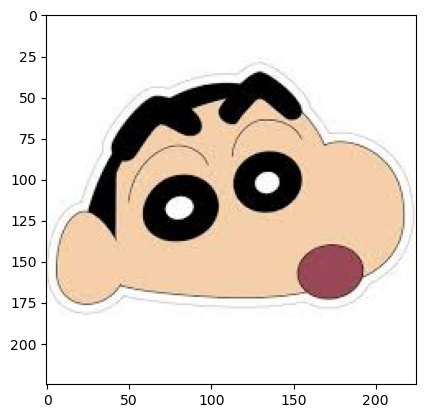

In [26]:
load_img = np.load('testdata.npy')
print(load_img.shape)
plt.imshow(load_img)

(1, 3, 225, 225)


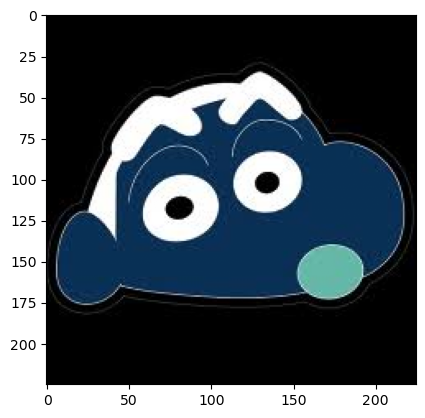

In [27]:
# preprocessing
# Normalization
img = 1 - load_img / 255.0

plt.imshow(img)

# make a shape of img (1, 3, 225, 225)
img = img.transpose(2, 0, 1)
test_img = img[None, :, :, :]
print(test_img.shape)

In [28]:
# 세로선을 찾는 필터
vertical_edge_kernel = np.array([
    [ # 첫 번째 출력 채널용 필터
        [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], # Red 채널용
        [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], # Green 채널용
        [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]  # Blue 채널용
    ]
])

# 가로선을 찾는 필터
horizontal_edge_kernel = np.array([
    [ # 두 번째 출력 채널용 필터
        [[-1, -1, -1], [0, 0, 0], [1, 1, 1]],
        [[-1, -1, -1], [0, 0, 0], [1, 1, 1]],
        [[-1, -1, -1], [0, 0, 0], [1, 1, 1]]
    ]
])

# 테두리를 찾는 필터
mid_point_kernel = np.array([
    [
        [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]],
        [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]],
        [[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]
    ]
])



filter_w = np.vstack((
    vertical_edge_kernel,
    horizontal_edge_kernel,
    mid_point_kernel
    ))
filter_name = [
    "vertical",
    "horizontal",
    "middle"
]

print(filter_w.shape)
print(filter_w[1])

bias = np.random.rand(filter_w.shape[0])

(3, 3, 3, 3)
[[[-1 -1 -1]
  [ 0  0  0]
  [ 1  1  1]]

 [[-1 -1 -1]
  [ 0  0  0]
  [ 1  1  1]]

 [[-1 -1 -1]
  [ 0  0  0]
  [ 1  1  1]]]


In [29]:
def create_vertical_kernel(size):
    """지정된 크기의 세로선 감지 커널을 생성합니다."""
    if size % 2 == 0:
        raise ValueError("커널 크기는 홀수여야 합니다 (중앙 열이 있어야 함).")
    
    kernel = np.zeros((size, size), dtype=np.float32)
    center_col_idx = size // 2 # 중앙 열의 인덱스

    # 중앙 열은 양수, 양옆 열은 음수 (가장 기본적인 형태)
    # 주변 영역은 부드럽게 감소시키는 형태도 가능하지만, 일단 단순하게.
    for i in range(size):
        for j in range(size):
            if j < center_col_idx:
                kernel[i, j] = -1
            elif j > center_col_idx:
                kernel[i, j] = 1
            else: # 중앙 열
                kernel[i, j] = 2 # 중앙을 더 강조
    
    # 커널의 값 합이 0이 되도록 정규화 (배경에 반응하지 않도록)
    # 이렇게 해야 밝기 변화에 둔감해지고 '선' 자체에 반응합니다.
    kernel = kernel - np.mean(kernel)
    
    return kernel

# 7x7 크기의 세로선 커널
k7 = create_vertical_kernel(7)
vertical_kernel_7x7 = np.stack([k7, k7, k7])
print("--- 7x7 세로선 감지 커널 ---")
print(vertical_kernel_7x7.shape)
print("\n")

# 15x15 크기의 세로선 커널
k15 = create_vertical_kernel(15)
vertical_kernel_15x15 = np.stack([k15, k15, k15])
print("--- 15x15 세로선 감지 커널 ---")
print(vertical_kernel_15x15.shape)
print("\n")

bigger_kernel = [
    vertical_kernel_7x7,
    vertical_kernel_15x15
]
print(bigger_kernel[1].shape)

# --- 시각화 ---
# fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# axes[0].imshow(vertical_kernel_7x7, cmap='RdBu', vmin=-np.max(np.abs(vertical_kernel_7x7)), vmax=np.max(np.abs(vertical_kernel_7x7)))
# axes[0].set_title("7x7 Vertical Kernel")
# axes[0].axis('off')

# axes[1].imshow(vertical_kernel_15x15, cmap='RdBu', vmin=-np.max(np.abs(vertical_kernel_15x15)), vmax=np.max(np.abs(vertical_kernel_15x15)))
# axes[1].set_title("15x15 Vertical Kernel")
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()

--- 7x7 세로선 감지 커널 ---
(3, 7, 7)


--- 15x15 세로선 감지 커널 ---
(3, 15, 15)


(3, 15, 15)


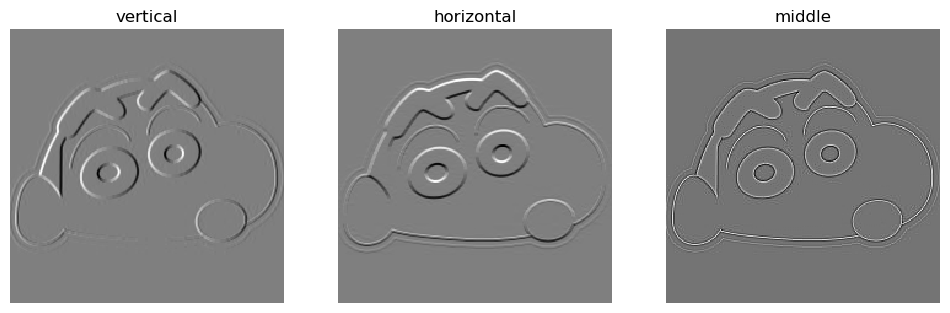

입력 형태: (1, 3, 225, 225)
im2col 변환 후 col 행렬 형태: (49729, 27)
최종 출력 형태: (223, 223, 3, 1)


In [30]:
# 합성곱 레이어 생성 및 실행
fig, axes = plt.subplots(1 ,3, figsize=(12, 6))
for i in range(filter_w.shape[0]):
    conv_layer = Convolution(filter_w, bias, stride=1, pad=0)
    result = conv_layer.forward(test_img)

    result = result.transpose(2, 3, 1, 0)
    axes[i].imshow(result[:, :, i], cmap='gray', interpolation='nearest')
    axes[i].axis('off')
    axes[i].set_title(filter_name[i])

plt.show()

print(f"입력 형태: {test_img.shape}") # (1, 3, 7, 7)
print(f"im2col 변환 후 col 행렬 형태: {im2col(test_img, 3, 3).shape}") # (25, 27) -> 5x5=25개 패치, 3x3x3=27개 픽셀
print(f"최종 출력 형태: {result.shape}")   # (1, 2, 5, 5) -> 2개 필터이므로 채널이 2

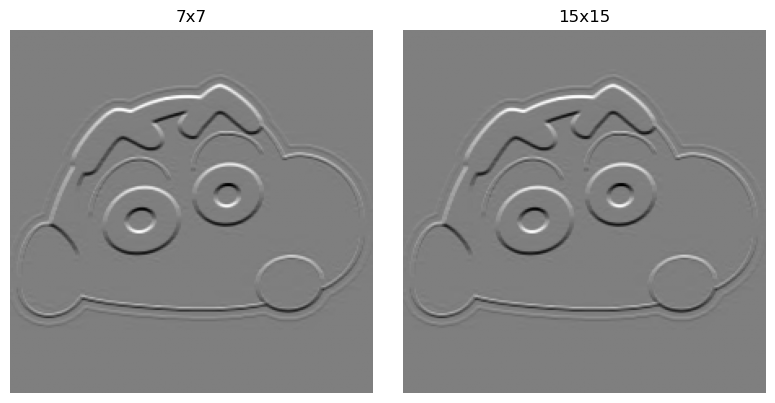

In [31]:
# 더 큰 커널을 사용
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for i in range(2):
    conv_layer_2 = Convolution(bigger_kernel[i], 0, stride=10)
    res = conv_layer.forward(test_img)

    res = res.transpose(2, 3, 1, 0)

    axes[i].imshow(res[:, :, 1], cmap="gray")
    axes[i].axis('off')
axes[0].set_title("7x7")
axes[1].set_title("15x15")
plt.tight_layout()
plt.show()


##### 깨끗하고 반듯한 이미지에서는 커널의 크기가 차이를 만들지 않는 듯하다.